Results :
<br><br>
<b>
<font color='green'>
Train Set Accuracy : 98 % <br>
Test Set Accuracy : 93 %
<br><br>
</font>
</b>
<b>
<font color='grey'>
Precision : 0.95<br>
Recall : 0.93<br>
F1 Score : 0.93<br>
ROC AUC : 0.998<br>
</font>
</b>

<br> <hr> 
<br> <b>APIS</b> <br><br>
End Point : http://144.91.87.204:7654/dog_breed 
```
Data Format : 
{
  'image' : Image 
}
```





<br><br>

<hr> 
<br>
<b>Model Weight</b><br><br>
https://drive.google.com/file/d/1-AQSt7Ft8eBkd7BdMTDdYWkxRD5W3M6F/view?usp=sharing
<br>



In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
!mv 'kaggle.json' '/root/.kaggle/kaggle.json'

In [ ]:
!kaggle competitions download -c dog-breed-identification

In [ ]:
!unzip '/content/dog-breed-identification.zip'

In [ ]:
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image  
import tensorflow as tf 
from tensorflow.keras.layers import * 
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
len(os.listdir('/content/train'))

10222

In [ ]:
len(os.listdir('/content/test'))

10357

In [ ]:
labels=pd.read_csv('labels.csv')

In [ ]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
classes=['beagle','chihuahua', 'doberman',
'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound',
'tibetan_mastiff']
x={} 
for t in classes :
  x[t]=0
classes=x

In [ ]:
for i in range(len(labels)):
  if labels.iloc[i,1] in list(classes.keys()):
    classes[labels.iloc[i,1]]+=1


NameError: ignored

In [ ]:
np.sum(list(classes.values()))

0

In [ ]:
classes_count=classes
classes=dict(enumerate(list(classes.keys())))
classes=dict([(v,k) for k,v in classes.items()])

In [ ]:
classes

{'beagle': 0,
 'chihuahua': 1,
 'doberman': 2,
 'french_bulldog': 3,
 'golden_retriever': 4,
 'malamute': 5,
 'pug': 6,
 'saint_bernard': 7,
 'scottish_deerhound': 8,
 'tibetan_mastiff': 9}

In [ ]:
ids=[]
for i in labels.index:
  if labels.loc[i,'breed'] in classes.keys() :
    pass 
  else :
    ids+=[i]

dataset=labels.drop(index=ids)
dataset=dataset.reset_index(drop=True)

In [ ]:
dataset.head()

,id,breed
0,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
1,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
2,008b1271ed1addaccf93783b39deab45,doberman
3,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
4,0100f55e4f0fe28f2c0465d3fc4b9897,golden_retriever


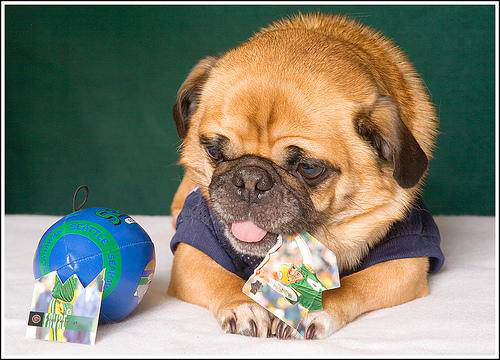

In [ ]:
Image.open('train/'+dataset.iloc[9,0]+'.jpg')

In [ ]:
val_ids=np.random.randint(0,len(dataset),size=100)
train_ids=np.array(list(set(range(len(dataset)))-set(val_ids)))
train_dataset=dataset.iloc[train_ids,:].reset_index(drop=True)
val_dataset=dataset.iloc[val_ids,:].reset_index(drop=True)

In [ ]:
def train_data_generator(batch_size=32):

  datagen = ImageDataGenerator( 
          rotation_range = 30, 
          shear_range = 0.3, 
          zoom_range = 0.3,  
          brightness_range = (0.7, 1.3))
  
  while True :
    ids=np.random.randint(0,len(train_dataset),size=batch_size)
    X=np.zeros(shape=(batch_size,224,224,3),dtype='float64')
    Y=np.zeros(shape=(batch_size,1))

    for i in range(batch_size) :
      img=Image.open('train/'+train_dataset.iloc[ids[i],0]+'.jpg').resize( (224,224))
      X[i,:]=np.array(img).astype('float64')
      Y[i,:]=classes[train_dataset.iloc[ids[i],1]] 

    X=datagen.flow(X,batch_size=X.shape[0],shuffle=False)[0].astype('float64')

    yield X,Y

In [ ]:
def val_data_generator(batch_size=32):

  datagen = ImageDataGenerator( 
          rotation_range = 30, 
          shear_range = 0.3, 
          zoom_range = 0.3,  
          brightness_range = (0.7, 1.3))
  
  while True :
    ids=np.random.randint(0,len(val_dataset),size=batch_size)
    X=np.zeros(shape=(batch_size,224,224,3),dtype='float64')
    Y=np.zeros(shape=(batch_size,1))

    for i in range(batch_size) :
      img=Image.open('train/'+val_dataset.iloc[ids[i],0]+'.jpg').resize( (224,224))
      X[i,:]=np.array(img).astype('float64')
      Y[i,:]=classes[val_dataset.iloc[ids[i],1]] 

    X=datagen.flow(X,batch_size=X.shape[0],shuffle=False)[0].astype('float64')

    yield X,Y

In [ ]:
ResNet=tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
# Freezing some Layers...
for layer in ResNet.layers[:-10]:
  layer.trainable=False

In [ ]:
# Building Top Layer of ResNet50...
t=GlobalAveragePooling2D()(ResNet.output)
t=Dropout(rate=0.4)(t)
t=Dense(units=len(classes),activation='softmax')(t)
model=tf.keras.models.Model(inputs=[ResNet.input],outputs=[t])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.000001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
model.fit_generator(train_data_generator(),steps_per_epoch=20,epochs=10,validation_data=val_data_generator(),validation_steps=5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
20/20 [==============================] - 19s 817ms/step - loss: 0.0068 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.4375 - val_sparse_categorical_accuracy: 0.8562
Epoch 2/10
20/20 [==============================] - 15s 783ms/step - loss: 0.0071 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.2293 - val_sparse_categorical_accuracy: 0.9312
Epoch 3/10
20/20 [==============================] - 15s 790ms/step - loss: 0.0089 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.4624 - val_sparse_categorical_accuracy: 0.8375
Epoch 4/10
20/20 [==============================] - 15s 793ms/step - loss: 0.0139 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.3857 - val_sparse_categorical_accuracy: 0.8813
Epoch 5/10
20/20 [==============================] - 15s 777ms/step - loss: 0.0149 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.3753 - val_sparse_categorical_accuracy: 0.8813
Epoch 6/10
20/20 [==============================] - 15s 760ms/step - loss: 0.0078 - sparse_cate

In [ ]:
model.load_weights('/content/drive/MyDrive/Datasets/DogBreed/model.h5')

In [ ]:
model.save('model.h5',save_format='h5')

In [ ]:
model.save_weights('/content/drive/MyDrive/Datasets/DogBreed/model.h5','h5')

**Evaluation of Model**

In [ ]:
# Accuracy Score on Validation Set...
# Score will vary (+/-)3% because of random image preprocessing
count=0
val_datagen=val_data_generator(100) 
X,Y=next(val_datagen)

model.evaluate(X,Y)

4/4 [==============================] - 0s 80ms/step - loss: 0.2145 - sparse_categorical_accuracy: 0.9300


[0.21452856063842773, 0.9300000071525574]

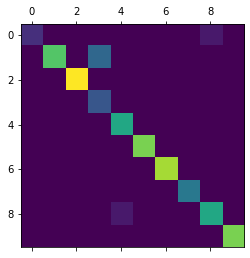

In [ ]:
# Confusion Matrix Visualization....

from sklearn.metrics import confusion_matrix 
cm=confusion_matrix(Y,np.argmax(model.predict(X),axis=-1))
plt.matshow(cm)
plt.show()

In [ ]:
# Confusion Matrix Array Viasualization on 100 Val Example
cm

array([[ 2,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0, 11,  0,  5,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 15,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  9,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 12,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 13,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  9,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 12]])

In [ ]:
# Percision Recall and F1 Score 
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score
precision=precision_score(Y,np.argmax(model.predict(X),axis=-1),average='weighted')
recall=recall_score(Y,np.argmax(model.predict(X),axis=-1),average='weighted')
f1=f1_score(Y,np.argmax(model.predict(X),axis=-1),average='weighted')
roc_auc=roc_auc_score(Y,model.predict(X),multi_class="ovr")
print('Precision : {}\nRecall : {}\nF1 Score : {}\nROC AUC : {}'.format(precision,recall,f1,roc_auc))

Precision : 0.9587777777777778
Recall : 0.93
F1 Score : 0.9342489128804918
ROC AUC : 0.9988579610538373


In [ ]:
user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
headers={'User-Agent':user_agent,} 

In [ ]:
def predict(url):
  request=urllib.request.Request(url,None,headers)
  img=urllib.request.urlopen(request)
  img=Image.open(img).resize((224,224))
  X=np.expand_dims(np.array(img).astype('float64'),axis=0) 
  Y=model.predict(X)
  return np.argmax(Y)

In [ ]:
predict('https://images.saymedia-content.com/.image/t_share/MTczOTA2OTM5NjIwMDQxNzky/pros-and-cons-of-owning-beagles.jpg')

0

In [ ]:
classes

{'beagle': 0,
 'chihuahua': 1,
 'doberman': 2,
 'french_bulldog': 3,
 'golden_retriever': 4,
 'malamute': 5,
 'pug': 6,
 'saint_bernard': 7,
 'scottish_deerhound': 8,
 'tibetan_mastiff': 9}